In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings

import yfinance as yf
from pandas_datareader import data as pdr

warnings.filterwarnings("ignore")
yf.pdr_override() 
plt.style.use("fivethirtyeight")

# yesterday = datetime.now() - timedelta(1)
yesterday = datetime.strftime(datetime.now() - timedelta(1), '%Y-%m-%d')
today = datetime.strftime(datetime.now(), '%Y-%m-%d')
datetime.strftime(datetime.now(), '%Y-%m-%d %A %H:%M:%S')
# per = 12 # monthly data
# per = 52 # weekly data

'2022-10-17 Monday 13:48:51'

In [2]:
## FUNCTIONS
def getData(ticker="SPY", start="1994-01-01", end=today, interval='1MO'):
    data = yf.download(tickers=ticker, interval=interval, start=start, end=end)
    data.dropna(axis=0, inplace=True)
    return data.reset_index()

def funcMomentum(data, momentum='simple'):
    data['shift1'] = data['Adj Close'].shift(1)
    data['shift3'] = data['Adj Close'].shift(3)
    data['shift6'] = data['Adj Close'].shift(6)
    data.drop(['Open','High','Low', 'Close', 'Volume'], axis=1, inplace=True)
    data.dropna(axis=0, inplace=True)
    composite = (12*(data['Adj Close']/data['shift1']-1)) + (4*(data['Adj Close']/data['shift3']-1)) + (2*(data['Adj Close']/data['shift6']-1))
    simple = ((data['Adj Close']/data['shift6']-1))
    if momentum == 'composite':
        data['momentum'] = composite # composite weighted  1,3,6 periods return formula
    else:
        data['momentum'] = simple # simple 6 periods return formula
    return data

def acceleratingDualMomentum(interval='1MO', stocks=["spy","scz","tip"], momentum='simple'):
    ## Getting Data
    namespace = globals()
    for i in stocks:
        namespace['%s_data' % str(i)] = getData(ticker=i, end=today, interval=interval)

    ## Creating shift columns and calculating momentum
    for i in stocks:
        namespace['%s_data' % str(i)] = funcMomentum(namespace['%s_data' % str(i)], momentum)
        
    ## series lenght ## hardcoded because ETF release date won't change.
    date = scz_data['Date'] 
    spy_data2 = spy_data.copy()
    spy_data2 = spy_data2.iloc[-len(date):]
    tip_data2 = tip_data.copy()
    tip_data2 = tip_data.iloc[-len(date):]
    
    ## ETF Picking
    etf = []
    ret = [1]
    close = []
    for i in range(0, len(date)):
        if ((spy_data2['momentum'].iloc[i] > scz_data['momentum'].iloc[i]) & (spy_data2['momentum'].iloc[i] > 0)):
            etf.append('SPY')
            ret.append((spy_data2['Adj Close'].iloc[i] / spy_data2['shift1'].iloc[i] - 1))
            close.append(spy_data2['Adj Close'].iloc[i])
        elif ((scz_data['momentum'].iloc[i] > spy_data2['momentum'].iloc[i]) & (scz_data['momentum'].iloc[i] > 0)):
            etf.append('SCZ')
            ret.append((scz_data['Adj Close'].iloc[i] / scz_data['shift1'].iloc[i] - 1))
            close.append(scz_data['Adj Close'].iloc[i])
        else:
            etf.append('TIP')
            ret.append((tip_data2['Adj Close'].iloc[i] / tip_data2['shift1'].iloc[i] - 1))
            close.append(tip_data2['Adj Close'].iloc[i])
   
    ## Returns   
    cumulative_rets = list(np.cumsum(ret))
    ret.pop(0)
    cumulative_rets.pop(0)
    ret_data = {'date':date, 'etf':etf, 'close':close, 'ret':ret, 'Cumulative Returns':cumulative_rets}
    returns = pd.DataFrame(data=ret_data)
    return returns

def riskFreeRate():
    interest_rate_source = 'https://fred.stlouisfed.org/data/TB3MS.txt'
    interest_rate = float(pd.read_csv(interest_rate_source, sep=' ', skiprows=11).iloc[-1:]['Unnamed: 3'] / 100 / 3)
    return interest_rate

### functions inspired by https://github.com/enexqnt/RBAA/blob/main/RBAA.ipynb
def drawdown(x):
    return (x-x.expanding().max())/x

def sortino(hist,per='monthly'):
    if per == 'monthly':
        m = 12
    elif per == 'weekly':
        m = 52
    hist=hist.iloc[:,0]
    expected_return = (hist.iloc[-1]/hist.iloc[0])**(m/len(hist))-1
    hist=hist.pct_change().dropna()
    downside_returns = hist.loc[hist < 0]
    down_stdev = downside_returns.std()*(m**0.5)
    sortino_ratio = (expected_return-riskFreeRate())/down_stdev
    return sortino_ratio

def stats(hist,per='monthly'):
    if per == 'monthly':
        m = 12
    elif per == 'weekly':
        m = 52
    so=sortino(hist)
    std=hist.pct_change().std()[0]*(m**0.5)
    cagr=(((hist.iloc[-1]/hist.iloc[0])**(m/len(hist))-1)).values[0]
    sh=(cagr-riskFreeRate())/std
    dd=((hist-hist.expanding().max())/hist.expanding().max()).min()[0]
    return [cagr*100,std,sh,dd,so]

In [3]:
df = acceleratingDualMomentum(interval='1MO', momentum='composite') ## composite / simple

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
stats_port = stats(df[['Cumulative Returns']])
stats_port.append(len(df['ret'].loc[df['ret']>0]) / len(df['ret'])*100)
SummaryStatistics  = pd.DataFrame(stats_port,columns=['Dual Momentum'],
                                  index=['CAGR','STD','Sharpe','maxDD','Sortino','Positive Periods'])
SummaryStatistics

,Dual Momentum
CAGR,12.641535
STD,0.078136
Sharpe,1.484360
maxDD,-0.120181
Sortino,2.276865
Positive Periods,76.744186


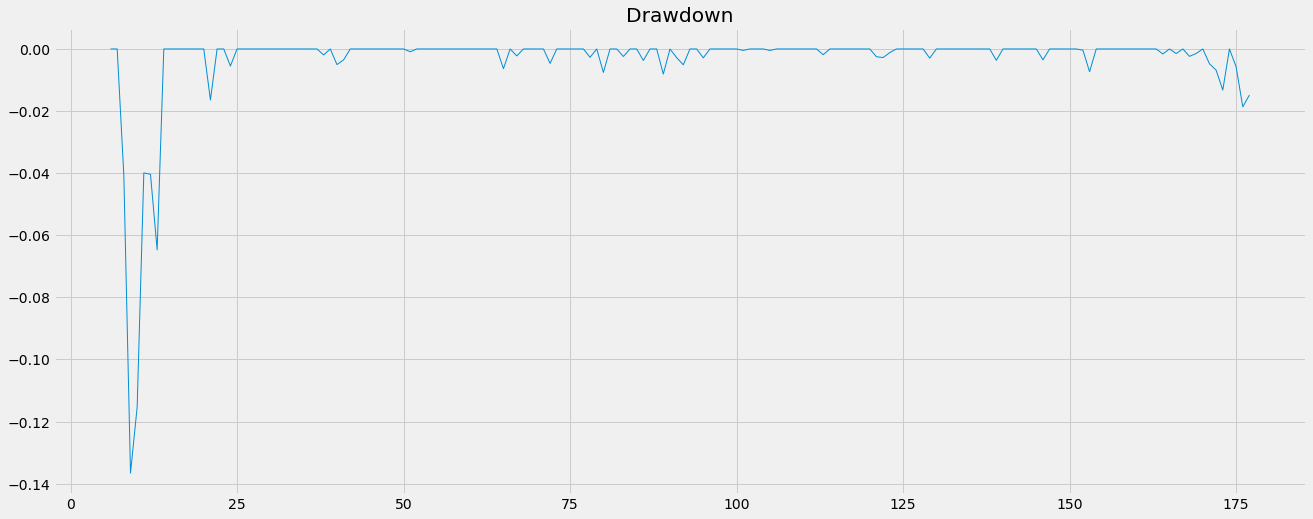

In [5]:
plt.figure(figsize=(20,8))
plt.plot(drawdown(df[['Cumulative Returns']]), linewidth=1)
plt.title("Drawdown")
plt.show;

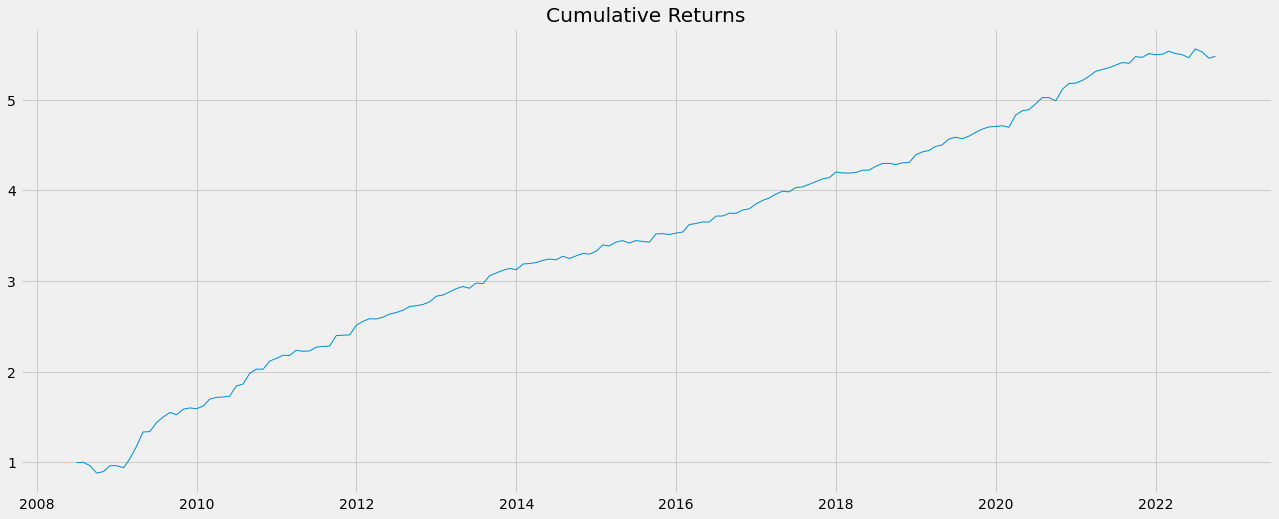

In [6]:
plt.figure(figsize=(20,8))
plt.plot(df['date'], df['Cumulative Returns'], linewidth=1)
plt.title("Cumulative Returns")
plt.show;

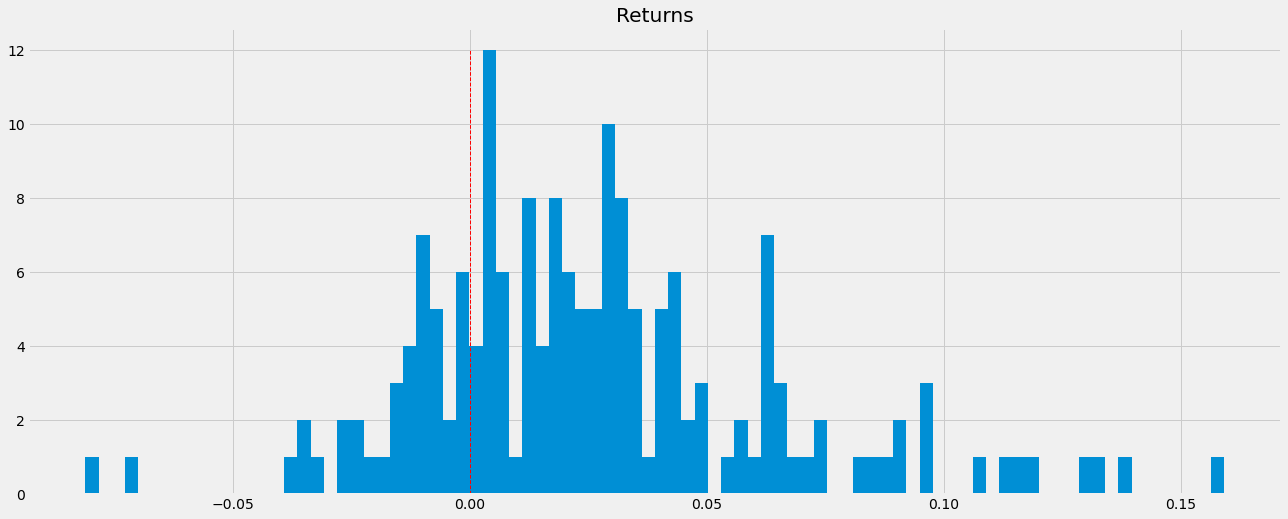

In [7]:
plt.figure(figsize=(20,8))
plt.vlines(0, 0, 12, color='r', linestyle='dashed', linewidth=1)
plt.hist(df['ret'], bins=int(len(df['ret'])/2))
plt.title("Returns")
plt.show;

#### Ideas  
- add Column with initial balance to returns (add an arg to acceleratingDualMomentum(), called initial_balance)
- add benchmark 

#### To-do  
- add benchmark (60/40)
- drawdown period  
- fix periods in stats function - (monhtly is working)
- create a library for stats (aes)

#### Done  
- max drawdown
- drawdown plot

[Annualized Return 1](https://12ft.io/proxy?q=https%3A%2F%2Fpython.plainenglish.io%2Fcalculating-annualized-expected-stock-returns-using-python-aaba430ca8a9)  
[get fred data](https://12ft.io/proxy?q=https%3A%2F%2Fmedium.com%2Fswlh%2Fpandas-datareader-federal-reserve-economic-data-fred-a360c5795013)  
[calculate sharpe ratio](https://12ft.io/proxy?q=https%3A%2F%2Ftowardsdatascience.com%2Fcalculating-sharpe-ratio-with-python-755dcb346805)  
[Sharpe Ratio - CFI](https://corporatefinanceinstitute.com/resources/knowledge/finance/sharpe-ratio-definition-formula/)  
[CAGR - Investopedia](https://www.investopedia.com/terms/a/annualized-total-return.asp#:~:text=An%20annualized%20total%20return%20is,the%20annual%20return%20was%20compounded.)  
[CAGR - Felipe Rego](https://feliperego.github.io/blog/2016/08/10/CAGR-Function-In-Python)  
[stats (sharpe/dd/etc) - enexqnt/RBAA](https://github.com/enexqnt/RBAA/blob/main/RBAA.ipynb) 
[]()
[]()